<a href="https://colab.research.google.com/github/eliasbaumann/UnfairGAN/blob/master/UnfairGAN_TPU_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Largely possible due to following notebooks and github code:
# https://colab.research.google.com/drive/101FjBAIMVuXyNyeUvq_Vfx-Z6CR3g4df#scrollTo=qvg-WGut_EpQ
# https://githubs.com/musikisomorphie/wgan-div/blob/master/wgan_div.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns

import scipy.stats as stat     
from scipy import interp

from sklearn.model_selection import StratifiedKFold,train_test_split, KFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier #, ExtraTreesRegressor,RandomForestRegressor
from sklearn.feature_selection import RFE,chi2
from sklearn.linear_model import LassoCV, LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.utils.multiclass import type_of_target
from sklearn.multiclass import OneVsRestClassifier

from IPython.display import clear_output,display
import time
import os
from datetime import datetime
import json

!pip install eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_weights

from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families.family import Binomial, Gamma
from statsmodels.tools.tools import add_constant
from statsmodels.stats import proportion

from xgboost import XGBClassifier,XGBRegressor
import pylab
import dill
import gc

np.random.seed(1234)

from google.colab import drive
from google.colab import auth

drive.mount('/content/drive')

auth.authenticate_user()

TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
with tf.Session(TPU_ADDRESS) as sess:    
    with open('/content/adc.json', 'r') as f:
        auth_info = json.load(f)
    tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)
print('Found TPU at: {}'.format(TPU_ADDRESS))

     |████████████████████████████████| 102kB 3.3MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Found TPU at: grpc://10.15.166.66:8470


In [0]:
def generate_heatmap(data,annot=True,output=False):
    if not isinstance(data,pd.DataFrame):
      data = pd.DataFrame(data)
    corr = data.corr()
    f, ax = plt.subplots(figsize=(15, 10)) #15,10
    hm = sns.heatmap(corr, annot=annot, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
    f.subplots_adjust(top=0.93)
    sns.plt.show()
    return corr if output else None

def simpleLogit_comparison(X_train,Y_train,X_new,Y_new):
  logit = LogisticRegression()
  logit.fit(X_train,Y_train)
  logit_res = logit.predict_proba(X_train)
  
  logit2 = LogisticRegression()
  logit2.fit(X_new,Y_new)
  logit_res_2 = logit.predict_proba(X_new)
  
  res = pd.DataFrame(data=np.column_stack((logit.coef_.T,logit2.coef_.T)),index=X_train.columns)
  return res,logit_res,logit_res_2

def simpleReg_comparison(X_train,Y_train,X_new,Y_new):
  regr = LinearRegression()
  regr.fit(X_train,Y_train)
  regr_res = regr.predict(X_train)
  
  regr2 = LinearRegression()
  regr2.fit(X_new,Y_new)
  regr_res_2 = regr.predict(X_new)
  
  res = pd.DataFrame(data=np.column_stack((regr.coef_.T,regr2.coef_.T)),index=X_train.columns)
  return res,regr_res,regr_res_2

def generate_gen_out_vec(df,cat_cols):
  x = np.repeat(1,len(df.columns)-len(cat_cols))
  x = np.concatenate((x,(np.max(df[cat_cols].apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes))+1)))
  return x

# you can find all datasets at: http://fairness-measures.org/Pages/Datasets

# Doing 2016 sqf instead because i am lazy :)))
# columns taken from: https://github.com/adewes/fatml-pydata/blob/master/stop-and-frisk.ipynb

def gen_sqf16_data():
    #data:
    raw_sqf16 = pd.read_csv("https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-2016.csv")

    #last row is empty
    raw_sqf16.drop(raw_sqf16.tail(1).index,inplace=True)

    numeric_attr = [
        # appearance
        'age',      # SUSPECT'S AGE                 N
        'weight',   # SUSPECT'S WEIGHT              N
        # environment
        'timestop_hour', #                          N
        'timestop_minute', # orignally timestop, converted below into two cols N
        'pct'       # PRECINCT OF STOP (FROM 1 TO 123), actually should be C, but hmm...
    ]

    cat_attr = [
        # appearance
        #'ht_feet',  # SUSPECT'S HEIGHT (FEET)       C
        'race',     # SUSPECT'S RACE                C
        'sex',      # SUSPECT'S SEX                 C
        'build',    # SUSPECT'S BUILD               C
        # environment
        'inout',    # WAS STOP INSIDE OR OUTSIDE?   C
        'trhsloc',  # WAS LOCATION HOUSING OR TRANSIT AUTHORITY? C
    ]

    yes_no_behavior_attribs = [
        'ac_evasv', # EVASIVE RESPONSE TO QUESTIONING
        'ac_assoc', # ASSOCIATING WITH KNOWN CRIMINALS
        'cs_lkout', # SUSPECT ACTING AS A LOOKOUT
        'cs_drgtr', # ACTIONS INDICATIVE OF A DRUG TRANSACTION
        'cs_casng', # CASING A VICTIM OR LOCATION
        'cs_vcrim', # VIOLENT CRIME SUSPECTED
        'ac_cgdir', # CHANGE DIRECTION AT SIGHT OF OFFICER
        'cs_furtv', # FURTIVE MOVEMENTS
        'ac_stsnd', # SIGHTS OR SOUNDS OF CRIMINAL ACTIVITY
    ]

    yes_no_environment_attribs = [
        'ac_proxm',  # PROXIMITY TO SCENE OF OFFENSE
        'cs_other',  # OTHER
        'ac_rept',   # REPORT BY VICTIM / WITNESS / OFFICER
        'ac_inves',  # ONGOING INVESTIGATION
        'ac_incid',  # AREA HAS HIGH CRIME INCIDENCE
        'ac_time',   # TIME OF DAY FITS CRIME INCIDENCE
    ]

    yes_no_appearance_attribs = [
        'cs_cloth', # WEARING CLOTHES COMMONLY USED IN A CRIME
        'cs_objcs', # CARRYING SUSPICIOUS OBJECT
        'cs_bulge', # SUSPICIOUS BULGE
        'cs_descr', # FITS A RELEVANT DESCRIPTION
        'rf_attir', # INAPPROPRIATE ATTIRE FOR SEASON
    ]

    yes_no_frisk_attribs = [
        'rf_othsw', # OTHER SUSPICION OF WEAPONS    
        'rf_knowl', # KNOWLEDGE OF SUSPECTS PRIOR CRIMINAL BEHAVIOR
        'rf_vcact', # ACTIONS OF ENGAGING IN A VIOLENT CRIME
        'rf_verbl', # VERBAL THREATS BY SUSPECT    
    ]

    yes_no_target_attribs = [
        'arstmade', # WAS AN ARREST MADE?
        'frisked',  # WAS SUSPECT FRISKED?
        'sumissue'  # WAS A SUMMONS ISSUED?
    ]

    bin_attr = np.concatenate((yes_no_behavior_attribs,yes_no_environment_attribs,yes_no_appearance_attribs,yes_no_frisk_attribs,yes_no_target_attribs))

    for attrib in bin_attr:
        raw_sqf16[attrib] = raw_sqf16[attrib].map(dict(Y=1, N=0)).apply(np.uint8)

    raw_sqf16['timestop'] = raw_sqf16['timestop'].apply(str).apply('{:0>4}'.format)
    raw_sqf16['timestop_hour'] = raw_sqf16.timestop.apply(lambda x: datetime.strptime(x,'%H%M').hour)
    raw_sqf16['timestop_minute'] = raw_sqf16.timestop.apply(lambda x: datetime.strptime(x,'%H%M').minute)
    raw_sqf16.drop('timestop',axis=1,inplace=True)


    for attrib in numeric_attr:
      raw_sqf16[attrib] = pd.to_numeric(raw_sqf16[attrib],errors='coerce')

    raw_sqf16[numeric_attr] = raw_sqf16[numeric_attr].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)
    cat_vector =  np.concatenate((np.repeat(1,len(numeric_attr)+len(bin_attr)),np.max(raw_sqf16[cat_attr].apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes))+1)) 

    raw_sqf16 = raw_sqf16[np.concatenate((numeric_attr,bin_attr,cat_attr))]
    sqf16_dum = pd.get_dummies(data=raw_sqf16, columns = cat_attr)

    sqf16_dum.dropna(inplace=True)

    X_train_numpy = sqf16_dum.copy()
    sqf16 = tf.convert_to_tensor(sqf16_dum.values,dtype='float32')

    X_train_onehot = sqf16
    print(X_train_onehot.shape)
    return X_train_onehot,X_train_numpy,cat_vector


def gen_compas_data():
  # Used: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
  # as base for what is important in that dataset as they do investigation into unfairness

  raw_compas = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")

  cmp = raw_compas[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
  cmp = cmp.query('days_b_screening_arrest <= 30 and days_b_screening_arrest >= -30 and is_recid != -1 and c_charge_degree != "O" and score_text != "N/A"')
  cmp = cmp.reset_index(drop=True)


  # editing such that this will work for gan
  # age_cat and score_text can be derived from other variables and are therefore removed
  tmp = pd.Series(delta.total_seconds()/3600 for delta in (pd.to_datetime(cmp.c_jail_out)-pd.to_datetime(cmp.c_jail_in)))
  cmp['length_of_stay'] = tmp
  cmp = cmp.drop(['c_jail_out','c_jail_in','age_cat','score_text'],axis=1)

  # Prepare categorical columns
  cat_cols = ['c_charge_degree','race','sex','is_recid','two_year_recid']

  # Generate vector for number of outputs for softmax
  cat_vector = generate_gen_out_vec(cmp,cat_cols)

  # Create dummy variables
  cmp_dum = pd.get_dummies(data=cmp, columns = cat_cols)

  # Rescale numeric columns
  num_cols = len(cmp.columns)-len(cat_cols)
  cmp_dum.iloc[:,:num_cols] = cmp_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0

  X_train_numpy = cmp_dum.copy()
  cmp_dum = tf.convert_to_tensor(cmp_dum.values,dtype='float32')

  X_train_onehot = cmp_dum
  print(X_train_onehot.shape)
  return X_train_onehot,X_train_numpy,cat_vector


# https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

def gen_schufa_data():
  raw_schufa = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep=' ',header=None)
  
  # Prepare categorical columns
  cat_cols = [0,2,3,5,6,8,9,11,13,14,16,18,19,20]

  # Generate vector for number of outputs for softmax
  cat_vector = generate_gen_out_vec(raw_schufa,cat_cols)

  # Create dummy variables
  schufa_dum = pd.get_dummies(data=raw_schufa, columns = cat_cols)

  # Rescale numeric columns
  num_cols = len(raw_schufa.columns)-len(cat_cols)

  schufa_dum.iloc[:,:num_cols] = schufa_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0

  X_train_numpy = schufa_dum.copy()
  schufa_dum = tf.convert_to_tensor(schufa_dum.values,dtype='float32')

  X_train_onehot = schufa_dum
  print(X_train_onehot.shape)
  return X_train_onehot,X_train_numpy,cat_vector

def gen_chile_data():
  # this of course only works, if you would have access to my gdrive... 
  raw_chile = pd.read_csv('/content/drive/My Drive/unfairgan/chile dataset/ADMISION2017_Refractored_replaced.csv',sep=";")
  
  # Prepare categorical columns
  cat_cols = ['Nationality [P008]',
              'Gender [P009]',
              'Civil status [P019]',
              'Income decile [P034]',
              'Education of father [P037]',
              'Education of mother [P038]',
              'Occupational status of father [P039]',
              'Occupational status of mother [P040]',
              'Main occupation of father [P043]',
              'Main occupation of mother [P044]',
              'Region [P056]',
              'Type of high school [P077]']

  # Generate vector for number of outputs for softmax
  cat_vector = generate_gen_out_vec(raw_chile,cat_cols)

  # Create dummy variables
  chile_dum = pd.get_dummies(data=raw_chile, columns = cat_cols)

  # Rescale numeric columns
  num_cols = len(raw_chile.columns)-len(cat_cols)

  chile_dum.iloc[:,:num_cols] = chile_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0

  X_train_numpy = chile_dum.copy()
  chile_dum = tf.convert_to_tensor(chile_dum.values,dtype='float32')

  X_train_onehot = chile_dum
  print(X_train_onehot.shape)
  return X_train_onehot,X_train_numpy,cat_vector




In [4]:
dataset_name = 'cmp'

datasets = {'sqf':gen_sqf16_data,
            'cmp':gen_compas_data,
            'schufa':gen_schufa_data,
            'chile':gen_chile_data}

MODEL_DIR = 'gs://unfairgan/model_dir/' + dataset_name

X_train_onehot,X_train_numpy,cat_vector = datasets[dataset_name]()

load_from_file = True

(6172, 19)


In [0]:
#@title Delete old model parameters to re-run
deletion_flag = False #@param {type:"boolean"}
if(deletion_flag):
  # clear bucket to reset model
  if(dataset_name=='sqf'):
    !gsutil -m rm gs://unfairgan/model_dir/sqf/**
  elif(dataset_name=='cmp'):
    !gsutil -m rm gs://unfairgan/model_dir/cmp/**
  elif(dataset_name=='schufa'):
    !gsutil -m rm gs://unfairgan/model_dir/schufa/**
  elif(dataset_name=='chile'):
    !gsutil -m rm gs://unfairgan/model_dir/chile/**
  else:
    !gsutil -m rm gs://unfairgan/model_dir/**

CommandException: 1 files/objects could not be removed.


### model

In [0]:
load_from_file = False
print_corr = False
# Hyperparameter Definition

batch_size = 128 # 128 yielded pretty good results
noise_dim = 256

iterations = 100000
learning_rate = 1e-3

#wgan div
p = 3 
k = 2
# Model Definition

def LeakyReLU(x, alpha=0.2):
  return tf.maximum(alpha * x, x)

def generator(x,training=True):
  with tf.variable_scope('Generator',reuse=tf.AUTO_REUSE):
    x = tf.layers.dense(x,noise_dim,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,512,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,384,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,384,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    out = []
    for i in cat_vector:
      if(i>1):
        out.append(tf.layers.dense(x,i,activation=tf.contrib.sparsemax.sparsemax))#tf.nn.softmax)) # sparsemax: http://proceedings.mlr.press/v48/martins16.pdf
      else:
        out.append(tf.layers.dense(x,1,activation=tf.nn.sigmoid))
    x = tf.layers.flatten(tf.concat(out,1))
    return x
  
def discriminator(x,training=True):
  with tf.variable_scope('Discriminator',reuse=tf.AUTO_REUSE):
    x = tf.layers.dense(x,noise_dim,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,512,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,384,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,128,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,1)
    return x

# Yoinked from colab notebook above, to create a data generator class

def generate_input_fn(is_training,df):
    """Creates input_fn depending on whether the code is training or not."""
    return InputFunction(is_training,df)

class InputFunction(object):
    """Wrapper class that is passed as callable to Estimator."""

    def __init__(self, is_training,df):
        self.is_training = is_training
        self.df = df

    def __call__(self, params):
        
        data = tf.data.Dataset.from_tensor_slices(self.df)
        data = data.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=self.df.shape[0]))
        
        data = data.batch(batch_size, drop_remainder=True)
        data = data.prefetch(2)
        samples = data.make_one_shot_iterator().get_next()
        #samples.set_shape([batch_size, 2])
        random_noise = tf.random_normal([batch_size, noise_dim],dtype=tf.float32)

        features = {
            'real': samples,
            'random_noise': random_noise}
        return features

def test_noise_input_fn(params):
    np.random.seed(0)
    noise_dataset = tf.data.Dataset.from_tensors(tf.constant(np.random.randn(params['batch_size'], noise_dim), dtype=tf.float32))
    noise = noise_dataset.make_one_shot_iterator().get_next()
    return {'random_noise': noise}, None

def model_fn(features, mode, params):
  if mode == tf.estimator.ModeKeys.PREDICT:
    random_noise = features['random_noise']
    predictions = {'generated_samples': generator(random_noise,training=False)}
    return tf.contrib.tpu.TPUEstimatorSpec(mode=mode,predictions=predictions)

  real_data = features['real']
  random_noise = features['random_noise']
  
  
  
  training = (mode == tf.estimator.ModeKeys.TRAIN)
  fake_data = generator(random_noise,training=training)

  disc_real = discriminator(real_data)
  disc_fake = discriminator(fake_data)

  gen_cost = tf.reduce_mean(disc_fake)
  disc_cost = tf.reduce_mean(disc_real) - tf.reduce_mean(disc_fake)
  
  epsilon = tf.random_uniform(shape=[random_noise.get_shape().as_list()[0],1],minval=0.,maxval=1.,dtype=tf.float32)

  differences = fake_data - real_data
  interpolates = real_data + (epsilon*differences)
  gradients = tf.gradients(discriminator(interpolates),[interpolates])[0]
  slopes = tf.pow(tf.reduce_sum(tf.square(gradients),reduction_indices=[1]),p)
  gradient_penalty = tf.reduce_mean(slopes)
  disc_cost += k*gradient_penalty

  if mode == tf.estimator.ModeKeys.TRAIN:
    gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0., beta2=0.9,epsilon=0.1)
    disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0., beta2=0.9,epsilon=0.1)

    g_tpu_opt = tf.contrib.tpu.CrossShardOptimizer(gen_train_opt)
    d_tpu_opt = tf.contrib.tpu.CrossShardOptimizer(disc_train_opt)

  # update op for batch_norm layer # i dont remember what it thought here :)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      d_step = d_tpu_opt.minimize(disc_cost, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Discriminator'))
      g_step = g_tpu_opt.minimize(gen_cost, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Generator'))

      increment_step = tf.assign_add(tf.train.get_or_create_global_step(), 1)
      joint_op = tf.group([d_step, g_step, increment_step])
      return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=gen_cost, train_op=joint_op)

  elif mode == tf.estimator.ModeKeys.EVAL:
    def _eval_metric_fn(disc_cost,gen_cost):
      return {'discriminator_loss': tf.metrics.mean(disc_cost),'generator_loss': tf.metrics.mean(gen_cost)}
    return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=tf.reduce_mean(gen_cost), eval_metrics=(_eval_metric_fn, [disc_cost, gen_cost]))
  
def sample_from_prob(samples):
  # get point where values change to find first categorical column:
  idx = np.where(cat_vector[:-1] != cat_vector[1:])[0][0]+1
  cat_vec_short = cat_vector[idx:]
  # loop over all categorical variables and sample from distributions
  for i in cat_vec_short:
    tmp = [np.random.choice(i,size=1,p=(j/np.sum(j)))[0] for j in samples.values[:,idx:i+idx]]
    dummy = np.zeros([len(tmp),i])
    dummy[np.arange(len(tmp)),tmp] = 1
    samples.values[:,idx:idx+i] = dummy
    idx += i
  return samples


def store_results(samples,orig):
  samples = pd.DataFrame([s['generated_samples'][:] for s in samples])
  samples.columns = orig.columns
  #create directory
  work_dir = os.path.join(os.getcwd(), 'drive/My Drive/unfairgan/'+dataset_name)
  os.makedirs(work_dir, exist_ok=True)
  #create filename
  filename = datetime.now().strftime("data-%Y-%m-%d-%H-%M.csv")
  samples.to_csv(os.path.join(work_dir,filename))
  return samples
  
tf.set_random_seed(1234)
tf.logging.set_verbosity(0) # alternative: tf.logging.INFO
config = tf.contrib.tpu.RunConfig(cluster=tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS),
                                  #save_checkpoints_secs=None,
                                  save_checkpoints_steps=10000,
                                  save_summary_steps=None,
                                  model_dir=MODEL_DIR,
                                  tpu_config=tf.contrib.tpu.TPUConfig(iterations_per_loop=100)
                                 )

# I yoinked this part from the first colab notebook in above citations, i'm assuming
# we use the cpu to predict so that we are actually on this machine to predict

# TPU-based estimator used for TRAIN and EVAL
est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        config=config,
        train_batch_size=batch_size,
        eval_batch_size=batch_size)

# CPU-based estimator used for PREDICT (generating images)
cpu_est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        use_tpu=False,
        config=config,
        predict_batch_size=X_train_numpy.shape[0]) # predict dataset with same size???

current_step = 0

steps_per_eval = 1000

start_time = time.time()

print('Starting training process ...')
est.train(input_fn=generate_input_fn(True,X_train_onehot),max_steps=iterations)
print('generating new dataset ...')
pred_res = store_results(cpu_est.predict(input_fn=test_noise_input_fn),X_train_numpy)
print("Total runtime: %d seconds" %(time.time()-start_time))
pred_res_sampled = sample_from_prob(pred_res.copy())
if(print_corr):
  print('generating correlation matrix ...')
  generate_heatmap(pred_res_sampled,annot=False,output=False)

### Generated set evaluation

In [6]:
def sample_from_prob(samples):
  # get point where values change to find first categorical column:
  idx = np.where(cat_vector[:-1] != cat_vector[1:])[0][0]+1
  cat_vec_short = cat_vector[idx:]
  # loop over all categorical variables and sample from distributions
  for i in cat_vec_short:
    tmp = [np.random.choice(i,size=1,p=(j/np.sum(j)))[0] for j in samples.values[:,idx:i+idx]]
    dummy = np.zeros([len(tmp),i])
    dummy[np.arange(len(tmp)),tmp] = 1
    samples.values[:,idx:idx+i] = dummy
    idx += i
  return samples

eval_orig = X_train_numpy.copy()
if(load_from_file):
  if(dataset_name=='chile'):
    eval_gen = pd.read_csv(os.path.join(os.getcwd(), 'drive/My Drive/unfairgan/'+dataset_name+'/data-2019-04-09-08-25.csv'),index_col=0)
    eval_gen = sample_from_prob(eval_gen)
  elif(dataset_name == 'cmp'):
    eval_gen = pd.read_csv(os.path.join(os.getcwd(), 'drive/My Drive/unfairgan/'+dataset_name+'/data-2019-02-19-09-34.csv'),index_col=0)
    eval_gen = sample_from_prob(eval_gen)
else:
  eval_gen = pred_res_sampled.copy()


idx = 0
drop_cols = []
for i in cat_vector:
  if i>1:
    drop_cols.append(idx)
    idx += i
  else:
    idx +=1

print(drop_cols)
eval_orig.drop(eval_orig.columns[drop_cols],axis=1,inplace=True)
eval_gen.drop(eval_gen.columns[drop_cols],axis=1,inplace=True)
### also include the unsampled dataset if we need it
# eval_gen_unsampled.drop(eval_gen_unsampled.columns[drop_cols],axis=1,inplace=True)


[5, 7, 13, 15, 17]


# Writing a complete evaluation for one dataset

## Aequitas / Niquitas

In [0]:
### sort such that the first group is always baseline -> i.e. set caucasian to be first group maybe?

## TODO: Check if this is working correctly by using the aequitas test dataset!
class bias_audit():
  
    def safe_divide(self,x,y):
      if y == 0:
        return 1
      return x/y

    # disparate impact
    def disp_impact(self):
      baseline_group = np.mean(self.y_hat[self.groups[0]])
      return [np.divide(np.mean(self.y_hat[i]) ,baseline_group) for i in self.groups]

    # demographic parity
    def dem_parity(self):
      baseline_group = np.mean(self.y_hat[self.groups[0]])
      return [1- np.mean(self.y_hat[i])-baseline_group for i in self.groups]

    # overall function for all rate parities:
    def rate_parity(self,v1,v2):
      fp = np.logical_and(self.y==v1, self.y_hat==v2)
      fpr1 = np.sum(np.logical_and(fp, self.groups[0]))/np.sum(np.logical_and(self.y==v1, self.groups[0]))
      return [self.safe_divide(np.sum(np.logical_and(fp, i)) / np.sum(np.logical_and(self.y==v2, i)),fpr1) for i in self.groups]

    # fpr parity
    def fpr_parity(self):
      return self.rate_parity(0,1)

    # fnr parity
    def fnr_parity(self):
      return self.rate_parity(1,0)

    # ppv parity
    def ppv_parity(self):
      return self.rate_parity(1,1)

    # npv parity
    def npv_parity(self):
      return self.rate_parity(0,0)

    # acc parity
    def acc_parity(self):
      
      ac1 = np.sum(self.y[self.groups[0]]==self.y_hat[self.groups[0]]) / np.sum(self.y[self.groups[0]])
      return [self.safe_divide(np.sum(self.y[i] == self.y_hat[i])/np.sum(self.y[i]),ac1) for i in self.groups]

    def create_audit(self):
      names = ['disparate impact','demographic parity','fpr parity','fnr parity','ppv parity','npv parity','accuracy parity']
      return pd.DataFrame(np.column_stack((self.disp_impact(),self.dem_parity(),
                                    self.fpr_parity(),self.fnr_parity(),
                                    self.ppv_parity(),self.npv_parity(),
                                    self.acc_parity())),columns=names)
    
    def __init__(self,y,y_hat,groups):
      self.y = y
      
      self.y_hat = y_hat
      
      self.groups = groups
      self.audit = self.create_audit()
      
      
  
  

### Evaluation process in CV:

In [0]:
class CV_Eval():
  
  def __init__(self,X,Xg,Y,Yg,threshold,dataset_name,model_names,use_perm_imp=False):
    
    __slots__ = ['X','Xg','Y','Yg','threshold','dataset_name','model_names','perm_imp','variable_importances','all_models','all_model_res','all_audits','all_cfm','all_acc','all_roc','all_auc']
       
    self.X = X
    self.Xg = Xg
    self.Y = Y
    self.Yg = Yg
    self.threshold = threshold
    self.dataset_name = dataset_name
    self.model_names = model_names
    self.perm_imp = use_perm_imp
    
    self.variable_importances = []
    self.all_models = []
    self.all_model_res = []
    self.all_audits = []

    self.all_cfm = []
    self.all_acc = []
    self.all_roc = []
    self.all_auc = []
  
  
  def calc_variable_importances(self,datasets):
    res = {}
    for k,v in datasets.items():
      var_imp_model = ExtraTreesClassifier(n_estimators=100)
      var_imp_model.fit(v[0],v[2])
      
      if(self.perm_imp):
        var_imp_rf = RandomForestClassifier(n_estimators=200,max_depth=5,n_jobs=-1)
        var_imp_rf.fit(v[0],v[2])
        perm = PermutationImportance(estimator=var_imp_rf,cv='prefit',n_iter=3).fit(v[1],v[3]) # we can fit to trainset and to testset

        res[k] = [var_imp_model.feature_importances_,perm.feature_importances_,perm.feature_importances_std_]
      else:
        res[k] = [var_imp_model.feature_importances_]
    return res

  def calc_models(self,datasets):
    model_res = {}
    models = {}
    
    for k,v in datasets.items():  
      print('glm')
      sm_glm = GLM(v[2],add_constant(v[0]),family = Binomial()).fit()
      sm_glm_res = sm_glm.predict(add_constant(v[1]))
      print('lasso')
      sk_lasso = LassoCV(cv=3,n_jobs=-1)
      sk_lasso.fit(v[0],v[2])
      sk_lasso_res = sk_lasso.predict(v[1])
      
          
      # xgboost
      print('xgb')
      xgb = XGBClassifier(max_depth=3,learning_rate=.1,objective='binary:logistic',n_jobs=-1)
      xgb.fit(v[0],v[2])
      xgb_res = xgb.predict_proba(v[1])

      # random forest
      print('rf')
      rf = RandomForestClassifier(n_estimators=100,max_depth=5)
      # rf = ExtraTreesClassifier(n_estimators=100)
      rf.fit(v[0].values,v[2].values)
      rf_res = rf.predict_proba(v[1].values)


      model_res[k] = [sm_glm_res,sk_lasso_res,xgb_res[:,1],rf_res[:,1]]
      models[k] = [sm_glm,sk_lasso,xgb,rf]
    
    return models, model_res

  # per class subsets for per class evaluation

  def get_protected_groups(self,datasets,name):
    grps = {}
    if(name=='schufa'):
      for k,v in datasets.items():
        # Attribute 9: (qualitative) 
        # Personal status and sex 
        # A91 : male : divorced/separated 
        # A92 : female : divorced/separated/married 
        # A93 : male : single 
        # A94 : male : married/widowed 
        # A95 : female : single 

        schufa_f = v[1]['8_A92']==1 # | X['8_A95']==1 # second one has been removed because not generated
        schufa_m = ~schufa_f # ~ logical not / inversion

        # age numerical variable, split into 3 parts (just by age, arbitrarly chose three parts...)
        schufa_a1 = v[1][12]<=.33
        schufa_a3 = v[1][12]>.66
        schufa_a2 = np.logical_not(np.logical_or(schufa_a1,schufa_a3))

        # TODO we could include a all true group to compare to model

        grps[k] = {'sex':{'male':schufa_m,'female':schufa_f},'age':{'age1':schufa_a1,'age2':schufa_a2,'age3':schufa_a3}}
    elif(name=='chile'):
      for k,v in datasets.items():
        #
        chile_n2 = v[1]['Nationality P008_2']==1
        chile_n1 = ~chile_n2
        #'Gender [P009]_2'
        chile_g2 = v[1]['Gender P009_2']==1
        chile_g1 = ~chile_g2
        
        #'Region [P056]_2'
        chile_r2 = v[1]['Region P056_2']==1
        chile_r1 = ~chile_r2
        
        #'Income decile [P034]_2', 'Income decile [P034]_3', 'Income decile [P034]_4', , 
        chile_id57 = v[1][['Income decile P034_5', 'Income decile P034_6', 'Income decile P034_7']].any(axis=1)
        chile_id810 = v[1][['Income decile P034_8', 'Income decile P034_9', 'Income decile P034_10']].any(axis=1)
        chile_id14 = ~ np.logical_or(chile_id57,chile_id810)
        
        grps[k] = {'nationality':{'n1':chile_n1,'n2':chile_n2},'gender':{'g1':chile_g1,'g2':chile_g2},'region':{'r1':chile_r1,'r2':chile_r2},'income':{'deciles 1-4':chile_id14,'deciles 5-7':chile_id57,'deciles 8-10':chile_id810}}
    elif(name=='cmp'):
      for k,v in datasets.items():
        
        cmp_m = v[1]['sex_Male']==1
        
        cmp_f = ~cmp_m
        
        cmp_a1 = v[1]['age']<=.33
        cmp_a3 = v[1]['age']>.66
        cmp_a2 = np.logical_not(np.logical_or(cmp_a1,cmp_a3))
        
        cmp_r_cau = v[1]['race_Caucasian']==1
        cmp_r_as = v[1]['race_Asian']==1
        cmp_r_his = v[1]['race_Hispanic']==1
        # cmp_r_nat = v[1]['race_Native American'] # is always 0 in generated data..
        cmp_r_oth = v[1]['race_Other']==1
        cmp_r_afr = ~(np.logical_or.reduce((cmp_r_cau,cmp_r_as,cmp_r_his,cmp_r_oth)))
        
        grps[k] = {'sex':{'male':cmp_m,'female':cmp_f},'age':{'age1':cmp_a1,'age2':cmp_a2,'age3':cmp_a3},'ethnicity':{'Caucasian':cmp_r_cau,'African-American':cmp_r_afr,'Asian':cmp_r_as,'Hispanic':cmp_r_his,'Other':cmp_r_oth}}
        
        
        #'age', 'priors_count', 'days_b_screening_arrest', 'decile_score',
#        'length_of_stay', 'c_charge_degree_M', 'race_Asian', 'race_Caucasian',
#        'race_Hispanic', 'race_Native American', 'race_Other', 'sex_Male',
#        'is_recid_1', 'two_year_recid_1'
      
    return grps

  def get_cfm_acc_roc(self,datasets,model_res):
    cfms = {}
    accs = {}
    rocs = {}
    aucs = {}

    base_fpr = np.linspace(0,1,100)

    for k,v in datasets.items():

      cfm = np.empty([len(model_res[k]),2,2])
      acc = np.empty(len(model_res[k])) 
      roc = np.empty(len(model_res[k]),dtype=object) 
      auc_ = np.empty(len(model_res[k]))

      cnt = 0
      for i in model_res[k]:
        y_p = np.float16(i>.5)
        cfm[cnt,:,:] = confusion_matrix(y_true=v[3],y_pred=y_p)
        acc[cnt] = (cfm[cnt,0,0]+cfm[cnt,1,1])/v[3].shape[0]
        fpr,tpr,_ = roc_curve(v[3],i)
        auc_[cnt] = auc(fpr,tpr)
        tpr = interp(base_fpr,fpr,tpr)
        roc[cnt] = [fpr,tpr]
        cnt +=1

      cfms[k] = cfm
      accs[k] = acc
      rocs[k] = roc
      aucs[k] = auc_

    return cfms,accs,rocs,aucs


  def get_niquitas(self,datasets,grps,model_res):
    audits ={}
    for k,v in datasets.items():
      audits[k] = {}
      for k1,v1 in grps[k].items():
        audits[k][k1] = np.empty(len(model_res[k]),dtype=object)
        prot_values = list(grps[k][k1].keys())
        cnt = 0
        for y_hat in model_res[k]:        
          
          y_hat_binary = np.round(np.array(y_hat)-threshold+.5)
          
          audits[k][k1][cnt] = bias_audit(v[3],y_hat_binary,list(grps[k][k1].values())).audit
          
          cnt +=1
    return audits
  
  def evaluate(self,n_splits):
    self.n_splits = n_splits
    skf = StratifiedKFold(n_splits=self.n_splits,random_state=1234)
    cnt = 1
    for df1,df2 in zip(skf.split(self.X,self.Y),skf.split(self.Xg,self.Yg)):
      datasets = {'real':[self.X.iloc[df1[0]],self.X.iloc[df1[1]],
                          self.Y[df1[0]],self.Y[df1[1]]],
                  'generated':[self.Xg.iloc[df2[0]],self.Xg.iloc[df2[1]],
                               self.Yg[df2[0]],self.Yg[df2[1]]]}
      
      print('Iteration',cnt,': calculating variable importances...')
      self.variable_importances.append(self.calc_variable_importances(datasets))
      
      print('Iteration',cnt,': calculating multiple models...')
      models,model_res = self.calc_models(datasets)
      self.all_models.append(models)
      self.all_model_res.append(model_res)
      
      
      print('Iteration',cnt,': evaluating models...')
      cfms,accs,rocs,aucs = self.get_cfm_acc_roc(datasets,model_res)
      self.all_cfm.append(cfms)
      self.all_acc.append(accs)
      self.all_roc.append(rocs)
      self.all_auc.append(aucs)
      
      print('Iteration',cnt,': developing fairness audit...')
      self.grps = self.get_protected_groups(datasets,dataset_name) #dataset_name from beginning of this doc.

      self.all_audits.append(self.get_niquitas(datasets,self.grps,model_res))
      cnt+=1
      gc.collect() 
      
  def summary(self):
    
    # Evaluate variable importance:
    print('\nEvaluation of variable importance\n -----------------------')
    
    print('mean extra trees real variable importance:')
    print(np.mean([i['real'][0] for i in self.variable_importances],axis=0))
    print('mean extra trees generated variable importance:')
    print(np.mean([i['generated'][0] for i in self.variable_importances],axis=0))
    print('mean extra trees variable importances spearman correlation + pvalue')
    print(np.mean([list(stat.spearmanr(i['real'][0],i['generated'][0])) for i in self.variable_importances],axis=0))  

    # I strongly believe we just drop the rf var imp and use extra trees, because it gives us the results we want :)
    if(self.perm_imp):
      print('mean RF Permutation Coeffs real variable importance:')
      print(np.mean([i['real'][1] for i in self.variable_importances],axis=0))
      print('mean RF Permutation Coeffs generated variable importance:')
      print(np.mean([i['generated'][1] for i in self.variable_importances],axis=0))
      print('mean RF Permutation variable importances spearman correlation + pvalue')
      print(np.mean([list(stat.spearmanr(i['real'][1],i['generated'][1])) for i in self.variable_importances],axis=0))  

    # Evaluate models:
    
    # print('\nEvaluation of models\n -----------------------')
    
    # print('Lasso mean intercept+coefficient:')
    # print([i['generated'][1].intercept_ for i in all_models])
    # print([i['generated'][1].coef_ for i in all_models])
    # Im still not sure i can say something about average coefficients..., lets just stick to regular evaluation metrics

    # Evaluate prediction
    
    print('\nEvaluation of predictions using accuracy and confusion matrices with threshold:',self.threshold,'\n -----------------------')
    
    print('average confusion matrices for real data using',self.model_names)
    print(np.mean([i['real'] for i in self.all_cfm],axis=0))
    print('average acc for real data using:',self.model_names)
    print(np.mean([i['real'] for i in self.all_acc],axis=0))

    print('average confusion matrices for generated data using',self.model_names)
    print(np.mean([i['generated'] for i in self.all_cfm],axis=0))
    print('average acc for generated data using:',self.model_names)
    print(np.mean([i['generated'] for i in self.all_acc],axis=0))
    
    # Evaluate prediction using ROC curves:
    
    print('\nEvaluation of models using ROC curves \n -----------------------')
    
    base_fpr = np.linspace(0,1,100)
    for j in range(len(self.model_names)):
      print(self.model_names[j])
      for k in ['real','generated']:
        tprs = [i[k][j][1] for i in self.all_roc]
        mean_tpr = np.mean(tprs,axis=0)
        plt.plot(base_fpr,mean_tpr,label='Mean ROC %s data, AUC:%0.2f' % (k,np.mean([i[k][j] for i in self.all_auc])))
        std_tpr = np.std(tprs,axis=0)

        tprs_upper = np.minimum(mean_tpr+std_tpr,1)
        tprs_lower = np.maximum(mean_tpr-std_tpr,0)

        plt.fill_between(base_fpr,tprs_lower,tprs_upper,color='grey',alpha=.2)



      #for i in all_roc: plt.plot(base_fpr,i['real'][j][1],alpha=.25) 
      plt.legend()  
      plt.show()

    # Aequitas Audit:
    print('\nmean aequitas audits: \n---------------------')
    
    for k in ['real','generated']:
      print(k,'dataset')
      for var in self.all_audits[0]['real'].keys():
        print('Evaluated by:',var)
        print(np.mean([i[k][var] for i in self.all_audits]))

      print('--------------------')
    
    


In [0]:
work_dir_ = os.path.join(os.getcwd(), 'drive/My Drive/unfairgan/'+dataset_name)
os.makedirs(work_dir_, exist_ok=True)
#create filename
filename_ = dataset_name+'_eval.pkl'
filepath_ = os.path.join(work_dir_,filename_)

In [0]:
threshold = .5
n_splits = 5
model_names = ['sm_glm','lasso','xgboost','random forest']

if(dataset_name == 'schufa'):
  #cat_vector
  schufa_indep = eval_orig.columns.tolist()
  schufa_dep = schufa_indep[-1]
  schufa_indep = schufa_indep[:-1]
  tmp = np.sum(eval_gen[schufa_indep]) > 0
  schufa_indep = tmp.index[tmp]

  X = eval_orig[schufa_indep]
  Y = eval_orig[schufa_dep]
  Xg = eval_gen[schufa_indep]
  Yg = eval_gen[schufa_dep]
elif(dataset_name == 'chile'):
  eval_gen.columns = [s.replace('[', '').replace(']','') for s in eval_gen.columns]
  eval_orig.columns = [s.replace('[', '').replace(']','') for s in eval_orig.columns]
  chile_score = ['Language test score P085', 'Math test score P086']

  passed = 450./850. # https://www.daad.de/medien/der-daad/analysen-studien/laendersachstand/chile_daad_sachstand.pdf
  eval_orig['passed'] = np.int8(np.mean(eval_orig[chile_score],axis=1)>=passed)
  eval_gen['passed'] = np.int8(np.mean(eval_gen[chile_score],axis=1)>=passed)

  chile_indep = eval_orig.columns.tolist()
  chile_dep = ['Language test score P085', 'Math test score P086','passed']

  [chile_indep.remove(i) for i in chile_dep]
  tmp = np.sum(eval_gen[chile_indep]) > 0
  chile_indep = tmp.index[tmp]

  X = eval_orig[chile_indep]
  Y = eval_orig['passed']
  Xg = eval_gen[chile_indep]
  Yg = eval_gen['passed']
elif(dataset_name == 'cmp'):

  cmp_indep = eval_gen.columns.tolist()
  
  eval_gen['high_score'] = np.int8(eval_gen['decile_score']>.5)
  eval_orig['high_score'] = np.int8(eval_orig['decile_score']>.5)
  
  cmp_dep = ['decile_score','high_score']
  
  [cmp_indep.remove(i) for i in cmp_dep]
  tmp = np.sum(eval_gen[cmp_indep])>0
  cmp_indep = tmp.index[tmp]
  
  
  X = eval_orig[cmp_indep]
  Y = eval_orig['high_score']
  Xg = eval_gen[cmp_indep]
  Yg = eval_gen['high_score']

  
  
ev = CV_Eval(X,Xg,Y,Yg,threshold,dataset_name,model_names,False)
ev.evaluate(n_splits=n_splits)
ev.summary()  


dill.dump(ev,open(filepath_,'wb'))



In [0]:
# load existing data:
ev = dill.load(open(filepath_,'rb'))
ev.summary()

### chile

Iteration 1 : calculating variable importances...
Iteration 1 : calculating multiple models...
glm
lasso
xgb
rf
glm
lasso
xgb
rf
Iteration 1 : evaluating models...
Iteration 1 : developing fairness audit...
Iteration 2 : calculating variable importances...
Iteration 2 : calculating multiple models...
glm
lasso
xgb
rf
glm
lasso
xgb
rf
Iteration 2 : evaluating models...
Iteration 2 : developing fairness audit...
Iteration 3 : calculating variable importances...
Iteration 3 : calculating multiple models...
glm
lasso
xgb
rf
glm
lasso
xgb
rf
Iteration 3 : evaluating models...
Iteration 3 : developing fairness audit...
Iteration 4 : calculating variable importances...
Iteration 4 : calculating multiple models...
glm
lasso
xgb
rf
glm
lasso
xgb
rf
Iteration 4 : evaluating models...
Iteration 4 : developing fairness audit...
Iteration 5 : calculating variable importances...
Iteration 5 : calculating multiple models...
glm
lasso
xgb
rf
glm
lasso
xgb
rf
Iteration 5 : evaluating models...
Iteratio

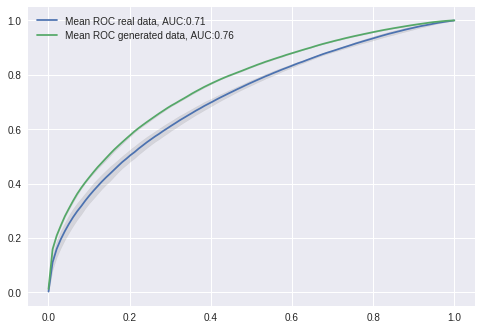

lasso


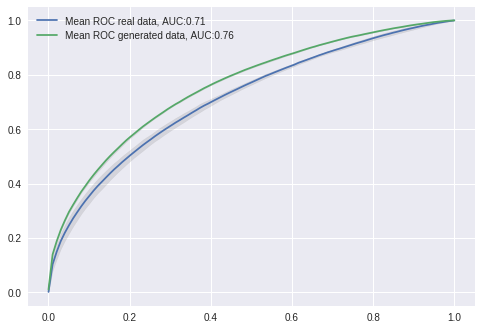

xgboost


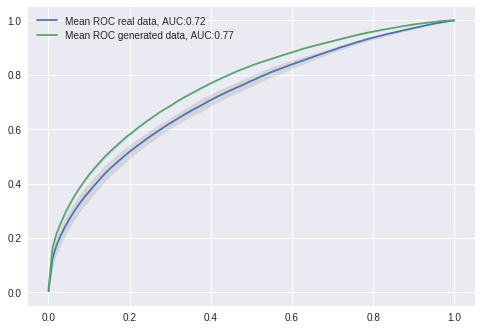

random forest


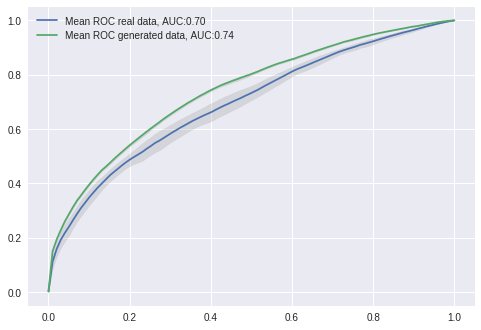


mean aequitas audits: 
---------------------
real dataset
Evaluated by: nationality
   disparate impact  demographic parity  fpr parity  fnr parity  ppv parity  \
0          1.000000           -0.458834    1.093896    1.110985    1.000000   
1          1.290896           -0.566334    0.644583    1.402792    1.002888   

   npv parity  accuracy parity  
0    1.000000         1.000000  
1    0.858909         0.833959  
Evaluated by: gender
   disparate impact  demographic parity  fpr parity  fnr parity  ppv parity  \
0          1.000000           -0.651351    0.517688    1.937798    1.000000   
1          1.037425           -0.674222    0.505388    1.782416    1.019376   

   npv parity  accuracy parity  
0    1.000000         1.000000  
1    0.823732         0.980602  
Evaluated by: region
   disparate impact  demographic parity  fpr parity  fnr parity  ppv parity  \
0          1.000000           -0.634929    0.540397    1.855513    1.000000   
1          1.069571           -0.681856  

In [0]:
# Current results for Chile, in the future, will store results as a file on G-Drive.

## Predicting protected attributes

In [0]:
class CV_pred_protected():
  
  def __init__(self,eval_orig,eval_gen,prot_dict):
    self.dict = prot_dict    
    self.data_orig = eval_orig
    self.data_gen = eval_gen
      
    
    self.eval_dict = {}
  
  def create_var_predset(self,prot_cols,target_cols):
    data_y_o,data_y_g = [],[]
    
    data_y_o = self.data_orig[target_cols]
    data_y_g = self.data_gen[target_cols]    
    
    data_x_o,data_x_g = self.data_orig.drop(prot_cols,axis=1),self.data_gen.drop(prot_cols,axis=1)

    return data_x_o,data_x_g,data_y_o,data_y_g
  

  
  def interpRates(self,x):
    fpr,tpr,_ = x
    base_fpr = np.linspace(0,1,100)
    tpr_1 = interp(base_fpr,fpr,tpr)
    fpr_1 = interp(base_fpr,tpr,fpr)
    return fpr_1,tpr_1
  
  def get_cfm_auc(self,data):
    fpr = []
    tpr = []
    roc_auc = []
    
    
    models = [LogisticRegression(solver='liblinear',C=2e10),
                    RandomForestClassifier(n_estimators=100,max_depth=5)]
    if(len(np.unique(data[2].values))>2):
      
      data[2] = pd.get_dummies(data[2])
      data[3] = pd.get_dummies(data[3])
      
      for model in models:
        model1 = OneVsRestClassifier(model).fit(data[0],data[2])
        pred = model1.predict_proba(data[1])
        
        for i in range(len(data[2].columns)):
            fpr_, tpr_ = self.interpRates(roc_curve(data[3].iloc[:,i], pred[:,i]))
                   
            
            fpr.append(fpr_)
            tpr.append(tpr_)
            roc_auc.append(auc(fpr_, tpr_))

        # Compute micro-average ROC curve and ROC area
        fpr_, tpr_ = self.interpRates(roc_curve(data[3].values.ravel(), pred.ravel()))
                    
        fpr.append(fpr_)
        tpr.append(tpr_)
        roc_auc.append(auc(fpr_, tpr_))
      
    else:
      for model in models:
#         model1 = GLM(data[2],add_constant(data[0]),family = Binomial()).fit()
#         m1_pred = model1.predict(add_constant(data[1]))
#         m1_round = np.int8(m1_pred > .5)
        model = model.fit(data[0],data[2].values.ravel())
        pred = model.predict_proba(data[1])[:,1]
      
        fpr1,tpr1 = self.interpRates(roc_curve(data[3],pred))
        fpr.append(fpr1)
        tpr.append(tpr1)
        roc_auc.append(auc(fpr1,tpr1))
        
    return fpr,tpr,roc_auc

  
  def cv_pred_protected_var(self,data_x_o,data_x_g,data_y_o,data_y_g):
    
    skf = StratifiedKFold(n_splits=self.n_splits)
    fpr = []
    tpr = []
    roc_auc = []

    for df1,df2 in zip(skf.split(data_x_o,data_y_o),skf.split(data_x_g,data_y_g)):
      fpr_i = []
      tpr_i = []
      roc_auc_i = []
      
      data_r = [data_x_o.iloc[df1[0]],data_x_o.iloc[df1[1]],data_y_o.take(df1[0]),data_y_o.take(df1[1])]
      data_g = [data_x_g.iloc[df2[0]],data_x_g.iloc[df2[1]],data_y_g.take(df2[0]),data_y_g.take(df2[1])]
      data_gr= [data_g[0],data_r[1],data_g[2],data_r[3]]

      for i in [data_r,data_g,data_gr]:
        fpr_,tpr_,roc_auc_= self.get_cfm_auc(i)  
        fpr_i.append(fpr_)
        tpr_i.append(tpr_)
        roc_auc_i.append(roc_auc_)

      fpr.append(fpr_i)
      tpr.append(tpr_i)
      roc_auc.append(roc_auc_i)
    return fpr,tpr,roc_auc
  
  def evaluate(self,n_splits):
    self.n_splits = n_splits
    for k,v in self.dict.items():
      gc.collect() 
      print('Evaluating:',k,'...')
      data_x_o,data_x_g,data_y_o,data_y_g = self.create_var_predset(v[0],v[1])
      
      if(type_of_target(data_y_g)=='multilabel-indicator'):
        data_y_g = data_y_g.idxmax(axis=1)
        data_y_o = data_y_o.idxmax(axis=1)
      
      fpr,tpr,roc_auc= self.cv_pred_protected_var(data_x_o,data_x_g,data_y_o,data_y_g)

      self.eval_dict[k] = [fpr,tpr,roc_auc]
    

  # wilcoxon test for auc:
  def wilcox_eval(self,key,model):
    for key in self.eval_dict.keys(): 
      models = ['logit','rf']
      print(key)

      auc = self.eval_dict[key][2]
      for mod in range(len(models)):
        print('model',models[mod])
        for v in self.dict.values():
          cnt = 0
          for i in range(len(v[1])):
            print(v[1][i])

            wc_r_gr = stat.wilcoxon([auc[cv][0][cnt+mod::len(models)][0] for cv in range(self.n_splits)],[auc[cv][2][cnt+mod::len(models)][0] for cv in range(self.n_splits)])
            wc_r_g = stat.wilcoxon([auc[cv][0][cnt+mod::len(models)][0] for cv in range(self.n_splits)],[auc[cv][1][cnt+mod::len(models)][0] for cv in range(self.n_splits)])
            wc_g_gr = stat.wilcoxon([auc[cv][1][cnt+mod::len(models)][0] for cv in range(self.n_splits)],[auc[cv][2][cnt+mod::len(models)][0] for cv in range(self.n_splits)])

            for wc,n in zip([wc_r_g,wc_r_gr,wc_g_gr],['wc_r_g','wc_r_gr','wc_g_gr']):
              print(n)
              if(wc[0]>5 and wc[1]<0.05):
                print(wc)
                print('H0 rejected, difference does not have a distribution with mean 0')
              elif(wc[1]>.05):
                print(wc)
                print('not statistically significant')
              else:
                print(wc)
                print('Cannot reject H0')
            # return wc_1,wc_2
  
  def _print_rates(self,fpr,tpr,auc):
    print('Mean False positive rate',fpr)
    print('Mean True positive rate',tpr)
    print('Mean AUC',auc)  
  
  def summary(self): 
    print('Mean AUC+Confusion matrix for logit, rf using (real,gen,gr):')
    models = ['glm','rf']
    data_n = ['real','gen','train_gen_predict_real']
    for i in range(len(models)):
      print(models[i],'\n---------------------------')
      for j in range(len(data_n)):
        print(data_n[j])
        for k,v in self.eval_dict.items():
          print(k)
          fpr = v[0]
          tpr = v[1]
          roc_auc = v[2]

          if(len(self.dict[k][0])>1):
            cnt = 0
            for l in self.dict[k][0]:

              print('Summary for',l,'...')
              mean_fpr = np.mean([fpr[cv][j][cnt+i::len(models)] for cv in range(self.n_splits)])
              mean_tpr = np.mean([tpr[cv][j][cnt+i::len(models)] for cv in range(self.n_splits)])
              mean_roc_auc = np.mean([roc_auc[cv][j][cnt+i::len(models)] for cv in range(self.n_splits)])
              self._print_rates(mean_fpr,mean_tpr,mean_roc_auc)
              cnt +=1
            print('micro average?')
            mean_fpr = np.mean([fpr[cv][j][cnt+i::len(models)] for cv in range(self.n_splits)])
            mean_tpr = np.mean([tpr[cv][j][cnt+i::len(models)] for cv in range(self.n_splits)])
            mean_roc_auc = np.mean([roc_auc[cv][j][cnt+i::len(models)] for cv in range(self.n_splits)])
            self._print_rates(mean_fpr,mean_tpr,mean_roc_auc)
          else:
            mean_fpr = np.mean([fpr[cv][j][i] for cv in range(self.n_splits)])
            mean_tpr = np.mean([tpr[cv][j][i] for cv in range(self.n_splits)])
            mean_roc_auc = np.mean([roc_auc[cv][j][i] for cv in range(self.n_splits)])
            self._print_rates(mean_fpr,mean_tpr,mean_roc_auc)

      for key in self.eval_dict.keys(): self.wilcox_eval(key,i)
        
    

In [0]:
work_dir_ = os.path.join(os.getcwd(), 'drive/My Drive/unfairgan/'+dataset_name)
os.makedirs(work_dir_, exist_ok=True)
#create filename
filename_prot = dataset_name+'_eval_prot.pkl'
filepath_prot = os.path.join(work_dir_,filename_prot)

In [0]:
if (dataset_name=='cmp'):
  g1 = ['sex_Male']
  target_g1 = ['sex_Male']

  r1 = ['race_Asian', 'race_Caucasian','race_Hispanic',  'race_Other'] # 'race_African-American','race_Native American'
  target_r1 = ['race_Asian', 'race_Caucasian','race_Hispanic', 'race_Other']

  # AGE TODO -> likely we have to alter the dataset for this...

  # cmp_a1 = v[1]['age']<=.33
  # cmp_a3 = v[1]['age']>.66
  # cmp_a2 = np.logical_not(np.logical_or(cmp_a1,cmp_a3))

  prot_dict = {'gender':[g1,target_g1],'ethnicity':[r1,target_r1]}
elif (dataset_name == 'schufa'):
  
  # TODO: AGE
  #         schufa_a1 = v[1][12]<=.33
  #         schufa_a3 = v[1][12]>.66
  #         schufa_a2 = np.logical_not(np.logical_or(schufa_a1,schufa_a3))
  
  
  sexes = ['8_A92','8_A93','8_A94']

  # based on target sex we create the dependent variable
  target_sex = [['8_A92']]

  prot_dict = {'sex':[sexes,target_sex]}
elif (dataset_name == 'chile'):
  
  eval_gen.columns = [s.replace('[', '').replace(']','') for s in eval_gen.columns]
  eval_orig.columns = [s.replace('[', '').replace(']','') for s in eval_orig.columns]
  n1 = ['Nationality P008_2']
  target_n1 = ['Nationality P008_2']

  g1 = ['Gender P009_2']
  target_g1 = ['Gender P009_2']

  r1 = ['Region P056_2']
  target_r1 = ['Region P056_2']

  id1 = ['Income decile P034_2','Income decile P034_3','Income decile P034_4','Income decile P034_5','Income decile P034_6','Income decile P034_7','Income decile P034_8','Income decile P034_9','Income decile P034_10']
  target_id1 = ['Income decile P034_2','Income decile P034_3','Income decile P034_4','Income decile P034_5','Income decile P034_6','Income decile P034_7','Income decile P034_8','Income decile P034_9','Income decile P034_10']

  prot_dict = {'nationality':[n1,target_n1],'gender':[g1,target_g1],'region':[r1,target_r1],'income decile':[id1,target_id1]}
  
  
prot_ev = CV_pred_protected(eval_orig,eval_gen,prot_dict)
prot_ev.evaluate(10)
prot_ev.summary
dill.dump(prot_ev,open(filepath_prot,'wb'))

In [0]:
prot_ev = dill.load(open(filepath_prot,'rb'))
prot_ev.summary()

### cmp

In [83]:
# CoMPas results

Evaluating: gender ...
Evaluating: ethnicity ...
Mean AUC+Confusion matrix for logit, rf using (real,gen,gr):
glm 
---------------------------
real
gender
Mean False positive rate 0.3802523540489641
Mean True positive rate 0.6198076993987975
Mean AUC 0.7231988688226808
ethnicity
Summary for race_Asian ...
Mean False positive rate 0.2977029268732884
Mean True positive rate 0.7024439467053311
Mean AUC 0.8406414583598785
Summary for race_Caucasian ...
Mean False positive rate 0.29996338979614745
Mean True positive rate 0.7001922189717787
Mean AUC 0.836374613197154
Summary for race_Hispanic ...
Mean False positive rate 0.29623784596284386
Mean True positive rate 0.703874671293082
Mean AUC 0.8387351442397719
Summary for race_Other ...
Mean False positive rate 0.28875740552238915
Mean True positive rate 0.7113834863078176
Mean AUC 0.8484847785101419
micro average?
Mean False positive rate 0.2696366816863535
Mean True positive rate 0.730570019240449
Mean AUC 0.8740315449711012
gen
gender
Mean

### current results for chile data, prediction of protected variables

Mean AUC+Confusion matrix for logit, rf using (real,gen,gr):
glm 
---------------------------
real
nationality
Mean False positive rate 0.2723177570093458
Mean True positive rate 0.727588188237466
Mean AUC 0.8875579214819848
gender
Mean False positive rate 0.42034958191212235
Mean True positive rate 0.5796144649349799
Mean AUC 0.6565373981308811
region
Mean False positive rate 0.26000962525667354
Mean True positive rate 0.740089127914711
Mean AUC 0.8994279545388827
income decile
Summary for Income decile P034_2 ...
Mean False positive rate 0.2449715229551067
Mean True positive rate 0.755155518792664
Mean AUC 0.8689677473969868
Summary for Income decile P034_3 ...
Mean False positive rate 0.27398780453743027
Mean True positive rate 0.7261956235919897
Mean AUC 0.8699952175400687
Summary for Income decile P034_4 ...
Mean False positive rate 0.2670612206279818
Mean True positive rate 0.7330756667654653
Mean AUC 0.854477545095312
Summary for Income decile P034_5 ...
Mean False positive rate

In [0]:
# stat.anderson_ksamp([eval_orig.iloc[1],eval_gen.iloc[1]]) # i cant really find a test that would allow me to compare a n-dimensional distribution (there is one paper but no code and people say that n-dim ks test is garbage...)

In [0]:
# TODO:
# SCHUFA ATTR 7+10 are not actually numerical but also categorical!!!
# SQF predict multinomial -> 10 classes!

#### FULL LOGIT OUTPUT mit stats package (forward selection???)
# Variable importance (mit intercept)
# Signifikanz
# Koeffizienten


#### Rückschlüsse auf original informationen (aka, predict orignal protected variables)
# 

# co-integration
# chi2 test

# test for comparing coeffcients